## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson

## Constants

In [2]:
NA = 6.02214076E23  # Avogadro's number
Ntrue = 217 #Number of ions used
k = 0.785  # units: kJ/mol/nm^2 - force constant being used in calculations
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant
T = 300  # units: K - temperature used for calculations
L_x, L_y, L_z = 4.8, 4.8, 14.4

## Extra info

In [3]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

<!-- exp_osm_coeff=0.936,molarity=0.976*(mole/litre)
exp_osm_coeff=0.984,molarity=1.923*(mole/litre)
exp_osm_coeff=1.045,molarity=2.823*(mole/litre) -->

## Plotting initial concentration profiles

In [4]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


In [5]:
z, c_original = compute_c_profile("density_hw_original_288.xvg")
z, c_1 = compute_c_profile("density_hw_r1.xvg")  # replicate 1
z, c_2 = compute_c_profile("density_hw_r2.xvg")  # replicate 2
z, c_3 = compute_c_profile("density_hw_r3.xvg")  # replicate 3

In [6]:
# List concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

### Normalizing Densities

Note from Dr Shirts: It is more rigorous to normalize the densities, since we know what the total number must be. 

Eq 13: $$ L_{x} L_{y} \int^{L_{z}/2}_{-L_{z}/2} C_{s}(z) dz = N_{s}$$

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)

for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should compare to number of ions used (3m used 188)
    c /= (N_s/Ntrue)
    
# # verify normalization worked.
# for c in concentration_profiles:
#     N_s = L_x * L_y * simpson(c, z)
#     print(N_s)  # compare to number of ions used (3m used 188)
    

217.00690232505607
217.003938339552
217.26231075196793
216.96056792831993


/tmp/ipykernel_199544/2072625792.py:4: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your i

Note BM: could maybe code up a funciton to check the above ^

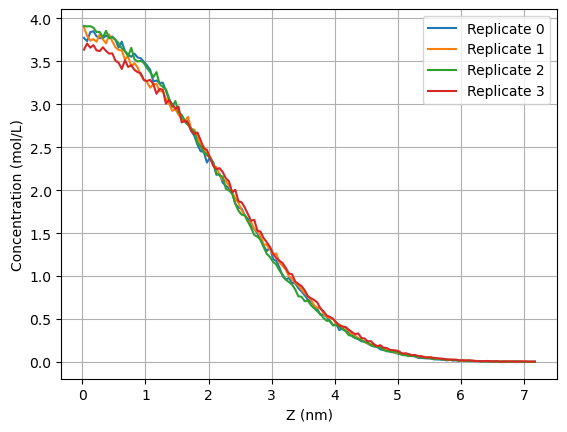

In [8]:
# Plot the concentration profiles (original and replicates)
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Calculating eq 12

$$ ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [9]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [10]:
#Use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
c_0 = mean_profile

# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [11]:
A = 1.7964  # in M^(-1/2), value according to the SI

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

In [12]:
# Right side/ y of equation 12
y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T) 

#Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

## Plotting unweighted results

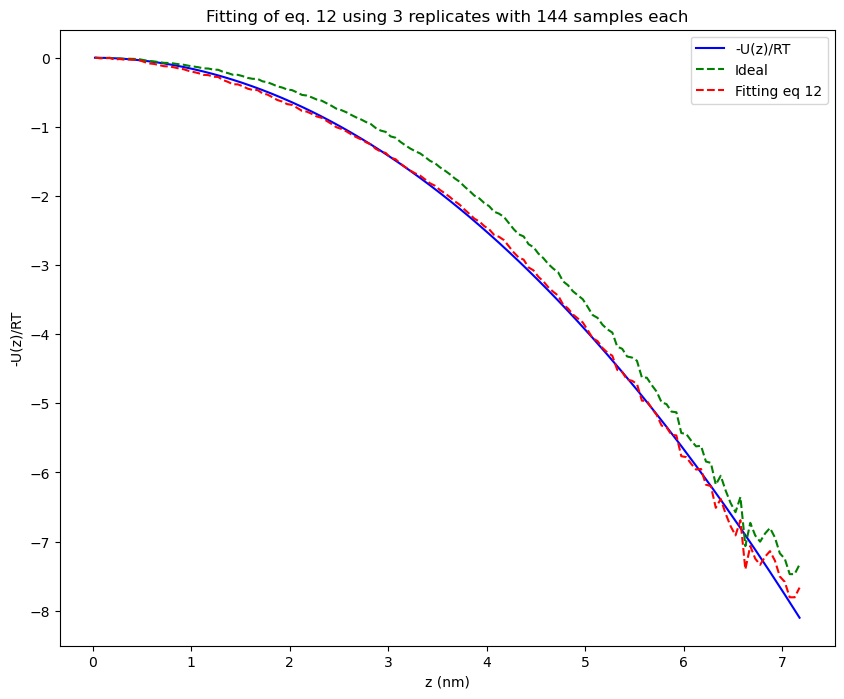

In [13]:
# plot the unweighted results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $|f'(x)| \delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

## Find weights for least square fit

In [14]:
norm = N_s/(L_x*L_y)
print(norm)

9.416691316333331


In [15]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [16]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

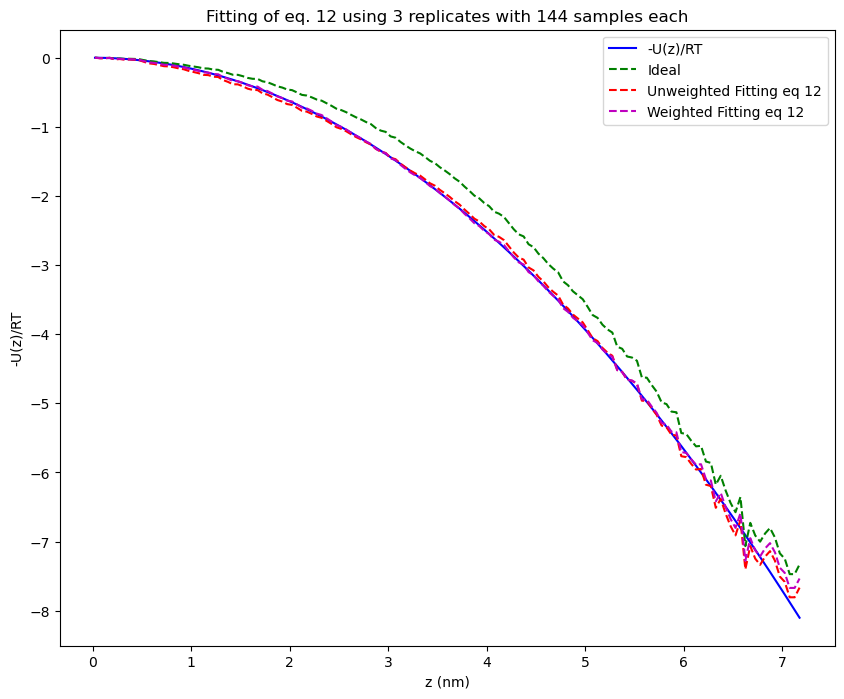

In [17]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

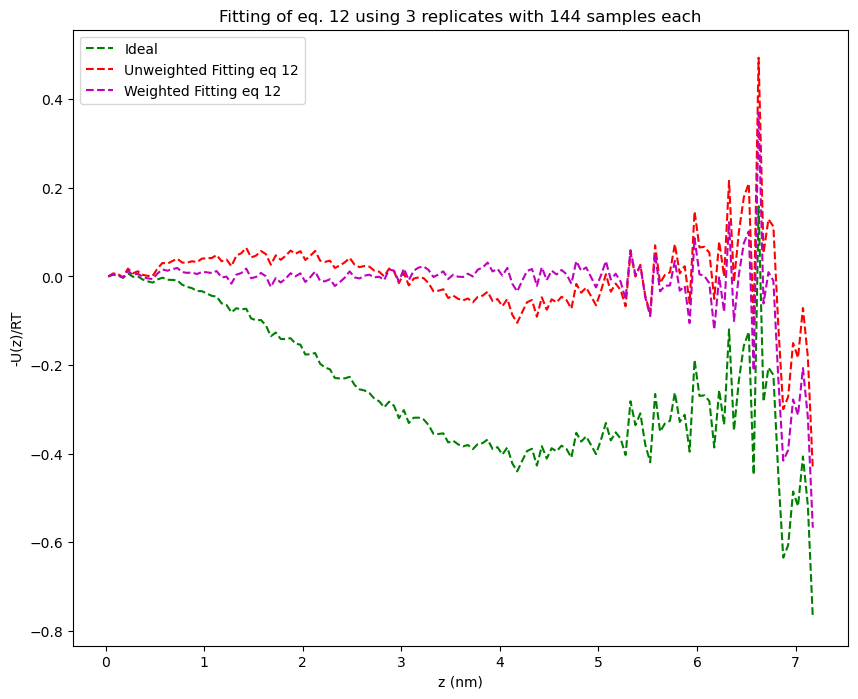

In [18]:
# plot the results. Notice the plots are now being subtracted from the y_values results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [19]:
zlim = 4 #coordinate limit for where fitting is closer

In [20]:
#Stdev of unweighted results
np.std(y_values[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))

0.03298181532693072

In [21]:
#Stdev of weighted results
np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))

0.01040629169745181

Compare the distribution of the parameters with the fit!

In [22]:
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

B = 22066.437298226414
alpha1 = -0.01060408206692025
alpha2 = 0.02592835184646411


In [23]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 2.443326667548713
alpha1 = 0.2119531741911878
alpha2 = -0.01334231297027398


And we expect that the parameters will be more consistent between runs with weighting.

## Bootstrapping Profiles (without and with weights)

In [24]:
trialp = [4, 0.1,0.0]

In [25]:
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Param 0 = 12716.61214434778 +/- 16312.43413803203


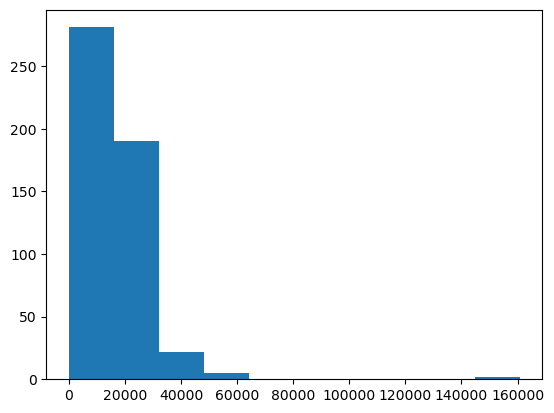

Param 1 = 0.24452302889958488 +/- 0.27931919113005466


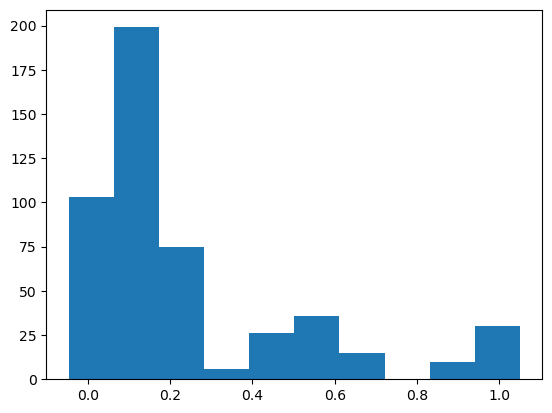

Param 2 = -0.013838439617940257 +/- 0.03340033538658624


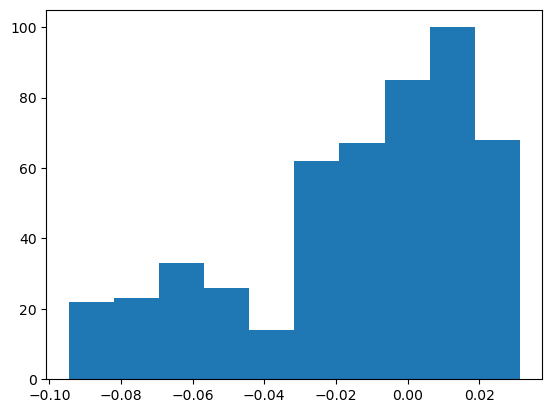

In [26]:
# Perform bootstrapping with unweighted fit
bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Param 0 = 2.0390043656705474 +/- 0.6150585212581623


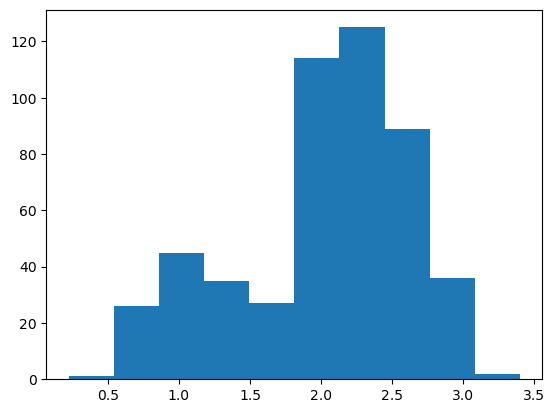

Param 1 = 0.261695525420475 +/- 0.0867377230405602


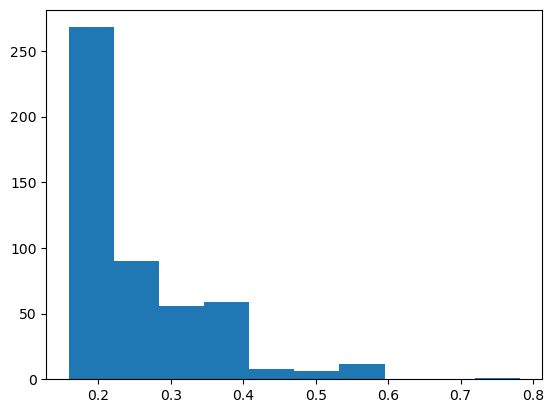

Param 2 = -0.020508682865738224 +/- 0.01171588960316976


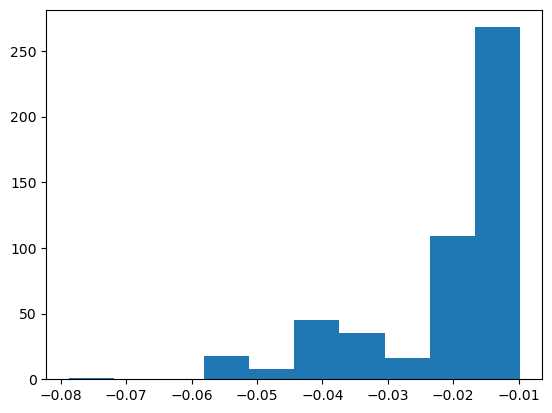

In [27]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=weighted_residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

## Maximum Likelihood Parameter Optimization

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

### The actual problem

We now apply the problem to the one of the chemical potential of ions trapped in a harmonic potential.

First, import the data.

In [28]:
import pickle
import pdb
import MDAnalysis as mda

In [29]:
u = mda.Universe('md.gro', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname SOD CLA')

u1 = mda.Universe('mdr1.gro', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname SOD CLA')

u2 = mda.Universe('mdr2.gro', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname SOD CLA')

u3 = mda.Universe('mdr3.gro', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname SOD CLA')

In [30]:
def get_ion_array(u,ions):
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data
    zvals=ionz.flatten()
    print(len(zvals))
    return zvals
zvals={}
zvals['original']=get_ion_array(u,ions)
zvals['r1']=get_ion_array(u1,ions1)
zvals['r2']=get_ion_array(u2,ions2)
zvals['r3']=get_ion_array(u3,ions3)


434434
434434
434434
434434


For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $x$, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [31]:
from scipy.integrate import quad, simpson, trapezoid

In [32]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

#Should not hard code k

In [33]:
ideal_norm = quad(cz_ideal,0,10)[0]
print(ideal_norm)
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
print(ideal_norm)

#are we checking these both yield approx the same?
#where did the second equation come from? Why pi?

2.2341010940709776
2.2341011392922034


In [34]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm)
print(cmax_ideal)

#same as cell above?

4.214979864034571


One issue is doing the integration of the model parameter to normalize it. 

We could try to take advantage of importance sampling - if we have two unnormalized probability distributions $q_i$ and $q_j$ ($p_i$ normalized), and we have samples from $q_i$, then we can have

$1 = \int p_j(z) dz \\
= \int \frac{p_j(z)}{p_i(z)}p_i(z) \\
= \int \frac{q_j(z)/Z_j}{q_i(z)/Z_i} p_i(z) \\
= \int \frac{Z_i}{Z_j} \frac{q_j(z)}{q_i(z)} p_i(z) \\
\approx \frac{Z_i}{Z_j} \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)} \\
\frac{Z_i}{Z_j} \approx \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)}
$

 So if we know the ideal solution normalizing factor, we can find

$Z_{trial} = Z_{ideal} \frac{1}{N} \sum_n \frac{q_{ideal}(z)}{q_{trial}(z)} =  Z_{ideal} \left \langle \frac{q_{ideal}(z)}{q_{trial}(z)} \right \rangle$

However, this doesn't actually appear work if we using this equation to optimize the parameters, because if we have a mismatch between the trial function and the data sampled; if the trial function functional form doesn't actually match the PDF measured, then we will continually get worse results.

Let's do something silly/simple and assume we have enough data, and just take the points that are output, and do Simpson's rule on those.

In [35]:
# define a function that iterates the calculation of a concentration.
def czfunc(a,z,cz):
    # exponential of eq 12 for ln c/cmax for the data points
    cznew = np.exp(logprobfunc(a,z,cz))
    # these indices do not need to be repeated if this is expensive,
    # but if we bootstrap, they will change, so keep for now. 
    zunique,locs = np.unique(z,return_index=True)
    # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],zunique)
    cznorm_ratio = ideal_norm/newarea
    return (cmax_ideal*cznorm_ratio)*cznew

In [36]:
def logprobfunc(a,z,cz,A=A):
    # we need to calculate the maximum concentration 
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [37]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

How many duplicates of each $z$ value are there?  

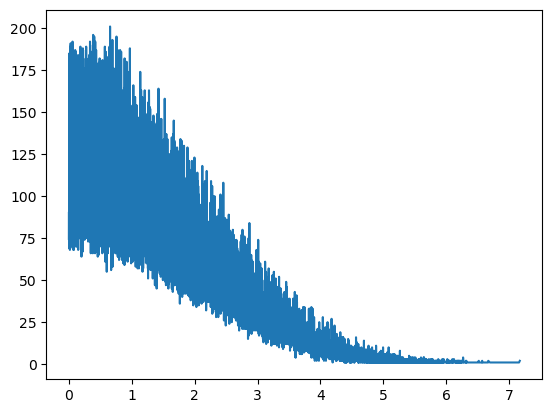

In [38]:
zsparse_o,zcount_o=np.unique(zvals['original'],return_counts=True)
zsparse_r1,zcount_r1=np.unique(zvals['r1'],return_counts=True)
zsparse_r2,zcount_r2=np.unique(zvals['r2'],return_counts=True)
zsparse_r3,zcount_r3=np.unique(zvals['r3'],return_counts=True)
plt.plot(zsparse_o,zcount_o,label='original')
plt.plot(zsparse_r1,zcount_r1,label='r1')
plt.plot(zsparse_r2,zcount_r2,label='r2')
plt.plot(zsparse_r3,zcount_r3,label='r3')
plt.legend()
plt.show()

Turns out, quite a few!  We can take advantage of that; each time the same $z$ is processed, it would result in the same number, so we can calculate the contribution for each $z$ once and then mulitply by the number of times it appears.

/tmp/ipykernel_199544/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 116.26807
1 12.6839075
2 2.1388824
3 0.38846645
4 0.07399595
5 0.0144402385
6 0.0028960763
7 0.000599404


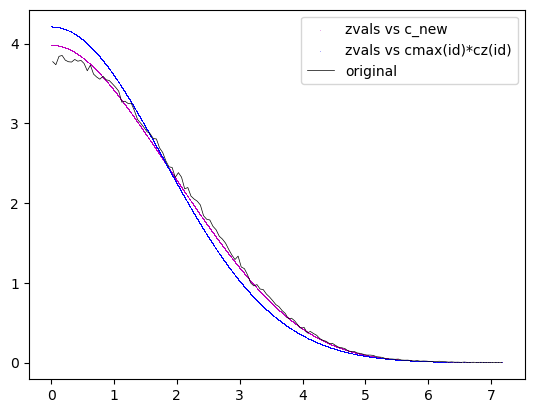

In [39]:
newp = np.array([1.35,0.33,-0.04])
c_new_o = converge_c(newp,zvals['original'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r1 = converge_c(newp,zvals['r1'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r2 = converge_c(newp,zvals['r2'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r3 = converge_c(newp,zvals['r3'],cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zvals['original'],c_new_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new')
plt.scatter(zvals['original'],cmax_ideal*cz_ideal(zvals['original']),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)',marker='-')
plt.scatter(zvals['r1'],c_new_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_new',marker='-')
plt.scatter(zvals['r1'],cmax_ideal*cz_ideal(zvals['r1']),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)',marker='-')
plt.scatter(zvals['r2'],c_new_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_new',marker='-')
plt.scatter(zvals['r2'],cmax_ideal*cz_ideal(zvals['r2']),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)',marker='-')
plt.scatter(zvals['r3'],c_new_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_new',marker='-')
plt.scatter(zvals['r3'],cmax_ideal*cz_ideal(zvals['r3']),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)',marker='-')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

/tmp/ipykernel_199544/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 14.368908
1 1.6693057
2 0.2842004
3 0.05206415
4 0.009977741
5 0.0019627505
6 0.00039552708


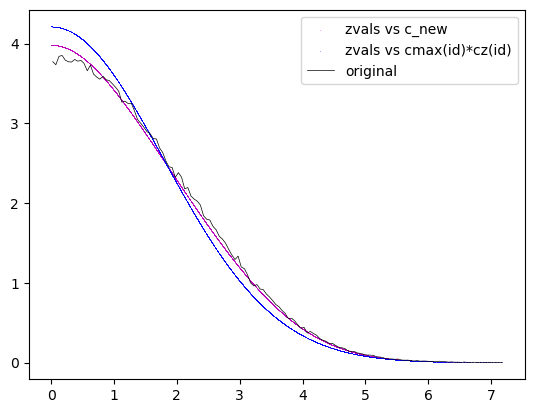

In [40]:
# we can converge faster with sparse data. (?)
newp = np.array([1.35,0.33,-0.04])
c_new_sparce_o = converge_c(newp,zsparse_o,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zsparse_o,c_new_sparce_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new',marker='-')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)',marker='-')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

In [41]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [42]:
from timeit import default_timer as timer

In [43]:
# summing over all the values is slow
start = timer()
results = minimize(neglliter,newp,args=(zvals['original'],c_new_o),method='Nelder-Mead',options={'maxiter':200})
# this one also works pretty well
#results = minimize(neglliter,newp,args=(zvals,c_new_o),method='COBYLA',options={'rhobeg':0.001})
end = timer()
print(end-start)

/tmp/ipykernel_199544/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 7.1580000e+00 7.1599998e+00
 7.1719999e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


KeyboardInterrupt: 

In [ ]:
# plot the results
print(results)
c_opt = converge_c(results.x,zvals['original'],cz_start=c_new_o,lim=0.0001,verbose=False)
optp = results.x
print(optp)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105705.28125
             x: [ 1.426e+00  3.141e-01 -3.308e-02]
           nit: 62
          nfev: 160
 final_simplex: (array([[ 1.426e+00,  3.141e-01, -3.308e-02],
                       [ 1.426e+00,  3.141e-01, -3.308e-02],
                       [ 1.426e+00,  3.141e-01, -3.308e-02],
                       [ 1.426e+00,  3.141e-01, -3.308e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


[ 1.42571846  0.31406065 -0.03308496]


In [ ]:
# yep, we have reduced the negative log likelihood, 
# i.e. maximized the likelihood
print(neglliter(newp,zvals['original'],c_new_o,doeval=True))
print(neglliter(optp,zvals['original'],c_opt,doeval=True))

105752.1640625
105705.3671875


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


See what the improved solution looks like! (red line vs magenta line)

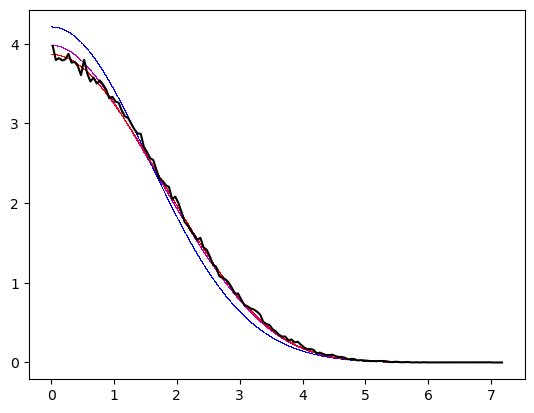

In [ ]:
plt.scatter(zvals['original'],c_new_o,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zvals['original'],cmax_ideal*cz_ideal(zvals['original']),s=0.1,lw=0.1,c='b')
plt.scatter(zvals['original'],c_opt,s=0.1,lw=0.1,c='r')
plt.show()

Note we can make this much faster by noting that there are a lot of repeats of each value, so we can simplify the sum (MIGHT be slightly different because of rounding).


In [ ]:
# this is now much faster, and gives essentially the same answer.
start = timer()
results = minimize(neglliter,newp,args=(zsparse_o,c_new_sparce_o,zcount_o),method='Nelder-Mead')
end = timer()
print("time=",end-start)
print(results)
full_opt = results.x

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


time= 1.1212125710444525
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105705.11869853735
             x: [ 1.432e+00  3.149e-01 -3.333e-02]
           nit: 76
          nfev: 175
 final_simplex: (array([[ 1.432e+00,  3.149e-01, -3.333e-02],
                       [ 1.432e+00,  3.149e-01, -3.333e-02],
                       [ 1.432e+00,  3.149e-01, -3.333e-02],
                       [ 1.432e+00,  3.149e-01, -3.333e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


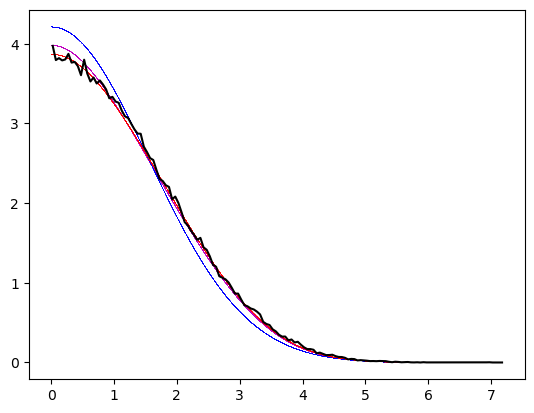

In [ ]:
# now plot the new data 
c_opt_sparse = converge_c(results.x,zsparse_o,cz_start=c_new_sparce_o,verbose=False)
plt.scatter(zsparse_o,c_new_sparce_o,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b')
plt.scatter(zsparse_o,c_opt_sparse,s=0.1,lw=0.1,c='r')
plt.show()

Note that the parameters are somewhat different, but the curves are about the same; the space appears to be relatively degenerate, in that there's a large volume of parameters that all give similar results. But that's probably OK for osmotic coefficients, as there will also be many parameters that thus give about the same osmotic coefficient. 

This seems to work!  Things to do:

1. Implement bootstrapping. A key here is one can now bootstrap over all the SAMPLES (like 188,000), not the profiles (4).
2. See what happens when you use all the data from the trajectories.  You can just dump them all into one big array - the bootstrapping is on samples, not on the trajectories.
3. See if you can get away with 2 paramters, not 3, and still get a good fit.  
4. Bootstrap around the osmotic coefficient/pressure calculation given the curve - this will be much less noisy than the parameters themselves. 


In [ ]:
# Function to perform bootstrapping over _samples_
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

In [ ]:
bparams,bcs = bootstrap_samples(zvals['original'],500,neglliter,results.x)

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 [ 2.36992318  0.23290305 -0.02312901] 105307.61260300898


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


1 [ 2.17880543  0.2054072  -0.0157077 ] 105168.51807436354


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


2 [ 2.51664483  0.22716229 -0.02159447] 105792.84710943268


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


3 [ 2.76356941  0.22126214 -0.02101587] 105917.06783475941
4 [ 2.41928925  0.24632982 -0.02629985] 105451.74653648425
5 [ 2.29277734  0.23997841 -0.02406913] 105446.97549368942


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


6 [ 1.74512705  0.25953558 -0.02415777] 105449.87307755144
7 [ 2.64135017  0.23279575 -0.0230553 ] 106008.80311663219


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


8 [ 3.48989273  0.18965023 -0.01650734] 105624.6885324654
9 [ 2.42025416  0.23374    -0.02275522] 105709.53382117512


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


10 [ 2.23183952  0.22500831 -0.02048272] 105253.89678124193
11 [ 2.21078307  0.24088461 -0.02348043] 105546.28677381891


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


12 [ 2.15484859  0.24815416 -0.02507241] 105427.61424105002
13 [ 2.12068967  0.24548438 -0.022982  ] 106014.59568952983


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


14 [ 2.92714762  0.18928755 -0.01543715] 105258.0816487878
15 [ 3.00576344  0.1790632  -0.01232387] 105682.01719716411
16 [ 2.81267665  0.19587554 -0.01632337] 105420.80270311063
17 [ 2.48656716  0.21198118 -0.01814966] 105680.61544442378
18 [ 2.79354564  0.21131818 -0.01858513] 106012.34914478479
19 [ 2.32141713  0.23872216 -0.02290011] 105933.43347068338
20 [ 2.37472157  0.22038355 -0.01867236] 106011.0622309995
21 [ 2.05751318  0.25550562 -0.02579038] 105558.23853931375
22 [ 2.18866543  0.22531597 -0.01918058] 105714.03314243285
23 [ 2.12659714  0.25398405 -0.02596197] 105552.49452014317
24 [ 2.42041841  0.197542   -0.01544972] 105108.5187242293
25 [ 2.35380057  0.23914051 -0.02383422] 105622.91362409257
26 [ 2.92110206  0.21458217 -0.01973763] 106040.67536339314
27 [ 3.26570836  0.17579009 -0.01290999] 105469.83485561052
28 [ 2.7971354   0.21732891 -0.02142398] 105377.43057381525
29 [ 4.09249607  0.17902092 -0.01508346] 105690.37163612356


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


30 [ 2.81353586  0.21090209 -0.01942384] 105593.6565301305
31 [ 2.06318028  0.24480007 -0.02388509] 105262.65110434701
32 [ 2.81135024  0.21916067 -0.01985076] 106297.71163276793


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


33 [ 2.98373337  0.17896198 -0.01151444] 106011.0179383068
34 [ 2.44957251  0.20573883 -0.01766144] 105050.03579542547


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


35 [ 2.90213144  0.1886464  -0.01420723] 105720.63636587758
36 [ 2.43814389  0.21705901 -0.01877488] 105784.44066103642
37 [ 2.97423931  0.21057632 -0.01915527] 105967.63467409366
38 [ 2.40123618  0.23299671 -0.02289425] 105495.98317774737
39 [ 2.24200894  0.23918043 -0.02366886] 105358.79808979707


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


40 [ 2.32796001  0.23653418 -0.0229885 ] 105600.82417966922
41 [ 3.56663592  0.18198595 -0.01486095] 105631.65151040809
42 [ 2.59236104  0.23507372 -0.02424586] 105519.44094401113
43 [ 2.5272156   0.20286661 -0.01639205] 105528.83651263377
44 [ 2.5285558   0.21322386 -0.01851198] 105680.77506524598
45 [ 2.44933533  0.21271989 -0.01808901] 105645.21001487484
46 [ 2.9073232   0.19273638 -0.01491308] 105872.45348866248
47 [ 2.74900384  0.1972414  -0.01628777] 105425.72564865154


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.7459998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


48 [ 3.80374468  0.19430253 -0.01750208] 105977.43244691749
49 [ 2.48845762  0.21081576 -0.01801862] 105564.25280286526
50 [ 2.42439366  0.21208155 -0.01711576] 105891.58722032295
51 [ 2.51701494  0.22999965 -0.02265638] 105625.11252642231
52 [ 2.44723329  0.23279943 -0.0227519 ] 105695.91256111093
53 [ 2.54267524  0.22348076 -0.0213223 ] 105561.98294837956
54 [ 2.27765002  0.21968744 -0.01921632] 105362.75895010236
55 [ 2.32799937  0.22447108 -0.02010041] 105694.45049067399
56 [ 2.63753411  0.22383957 -0.02129053] 105776.0696774947
57 [ 2.8598464   0.1831248  -0.01289399] 105615.68389704038
58 [ 1.96876412  0.2542944  -0.02560918] 105141.8909791807


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


59 [ 2.50881476  0.24544344 -0.02529518] 105998.09636681253
60 [ 2.5873086   0.21795174 -0.02025372] 105555.23004286316
61 [ 2.06002324  0.26785183 -0.02803339] 105939.73917433001
62 [ 2.62463188  0.22305795 -0.0203805 ] 106090.2304902207
63 [ 3.01161474  0.20368951 -0.01814972] 105753.385928798


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


64 [ 2.56511782  0.21711008 -0.01965634] 105670.16198327235


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


65 [ 2.41625656  0.21680017 -0.0182405 ] 105915.75471432139


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


66 [ 2.83770732  0.19959625 -0.0165345 ] 105729.18972238526
67 [ 2.6482962   0.21257141 -0.01888362] 105683.9326734268
68 [ 2.3606246   0.23424337 -0.02251941] 105739.27622939715
69 [ 2.87512054  0.19186284 -0.01390907] 106138.07665810575
70 [ 2.15062684  0.23325977 -0.02157781] 105440.65053696746
71 [ 1.77259006  0.29069305 -0.03093108] 105923.67764727105
72 [ 1.98228484  0.24622056 -0.02365409] 105279.27251683609


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


73 [ 1.75324092  0.27771087 -0.0286982 ] 105386.96960026972
74 [ 1.92674753  0.25789511 -0.02447205] 105961.23108470342
75 [ 3.20522971  0.18783828 -0.0142734 ] 106103.87381107348
76 [ 2.68576104  0.20832904 -0.01803326] 105728.65591243339
77 [ 2.70351741  0.20762115 -0.01835878] 105535.35969908486
78 [ 2.50201404  0.23183161 -0.02185278] 106098.78534077045
79 [ 1.56654416  0.29874645 -0.03096153] 105700.03237903354
80 [ 2.08931607  0.23587643 -0.02127022] 105641.28413068222


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


81 [ 3.32897461  0.1759636  -0.01245088] 105777.56091982988
82 [ 3.19554008  0.18812866 -0.01586855] 105367.13189274912
83 [ 3.31610648  0.19356655 -0.01627738] 105937.75711898087
84 [ 1.87331108  0.2619309  -0.02585839] 105539.4285362124
85 [ 2.46095198  0.22254988 -0.02000189] 105845.82232911998
86 [ 2.30425426  0.22968537 -0.02042128] 106027.16668066593
87 [ 2.38052433  0.21836693 -0.01872903] 105759.3200385366


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


88 [ 2.05629418  0.25416446 -0.02552786] 105551.87091481166
89 [ 1.75930592  0.27580792 -0.0281979 ] 105455.60346602314
90 [ 2.74900247  0.20128014 -0.01663565] 105730.03383599757
91 [ 2.4796312   0.21547835 -0.01912024] 105535.57474055173
92 [ 2.59844241  0.21245074 -0.0203436 ] 104912.45504969743
93 [ 2.19487931  0.23385992 -0.02137667] 105734.1746047585
94 [ 2.86799283  0.19284734 -0.01494814] 105772.09713693702


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


95 [ 3.03136645  0.19914538 -0.01737835] 105618.0962597512
96 [ 2.03316308  0.23966336 -0.02393407] 104617.49068297146
97 [ 2.2726972   0.23537022 -0.02162234] 105979.9251185865
98 [ 2.48146846  0.23035942 -0.02166543] 105958.16724121264
99 [ 3.01018871  0.20185531 -0.01728208] 105917.17061413723
100 [ 3.08217188  0.19155907 -0.01518091] 105886.63868563816


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


101 [ 2.01786221  0.26893145 -0.02839183] 105715.62622853072


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


102 [ 2.28100327  0.23704294 -0.02302202] 105604.6325059214
103 [ 3.00945647  0.18669411 -0.01570371] 105078.76533516125
104 [ 2.16513055  0.25855239 -0.02678537] 105828.98146656995
105 [ 2.51202444  0.21951625 -0.01866414] 106256.4651050827


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


106 [ 3.17911001  0.18147741 -0.01433331] 105304.06844933942
107 [ 2.46347583  0.24520622 -0.02473106] 106150.0128957013
108 [ 2.75828829  0.19420555 -0.01541265] 105480.69111596141
109 [ 2.72772166  0.23491627 -0.02430336] 105831.48007234513


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


110 [ 3.90032452  0.17480492 -0.0135369 ] 105787.67662281032
111 [ 2.18050231  0.23567897 -0.02154806] 105769.95659195473
112 [ 2.30322602  0.23965486 -0.02309807] 105856.8631504732
113 [ 2.03766528  0.24742382 -0.02344563] 105706.70534373654
114 [ 2.35000673  0.23984701 -0.02357007] 105796.57887848628
115 [ 2.23828197  0.24009687 -0.02299132] 105784.36303816363


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


116 [ 1.95801031  0.24846718 -0.02382469] 105308.41310409493
117 [ 2.48747383  0.23040447 -0.02246999] 105669.31085504581
118 [ 2.38970085  0.22936577 -0.02249724] 105301.79739571386
119 [ 2.4850518   0.22268346 -0.01984224] 105984.63508616784
120 [ 2.0923997   0.24532307 -0.02412395] 105303.22120922995
121 [ 2.43379766  0.22069118 -0.01936236] 105859.1732224707


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.5820007e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


122 [ 1.53806119  0.29338195 -0.02998756] 105320.9719511813
123 [ 3.63689603  0.18154396 -0.01397759] 106066.75001639605


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.5820007e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


124 [ 2.99832735  0.20719585 -0.01846811] 105958.57112859923
125 [ 2.33798233  0.23401659 -0.02212163] 105814.6236374214
126 [ 2.34061294  0.21580916 -0.01816515] 105628.91518374177


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


127 [ 2.36180251  0.21440115 -0.01734995] 105881.75399449734
128 [ 1.89667118  0.26276539 -0.02497367] 106091.95297312847


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


129 [ 2.51527525  0.22560224 -0.02112012] 105783.2402979293
130 [ 2.82792702  0.19671668 -0.01536028] 105931.9748614899


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


131 [ 2.37473827  0.23647882 -0.022884  ] 105781.72833628392
132 [ 2.53921548  0.24167762 -0.02375711] 106405.16787657494
133 [ 2.0414332   0.24761097 -0.02366257] 105593.19464805421
134 [ 2.83711325  0.2108734  -0.0197655 ] 105478.37424655401
135 [ 2.90141023  0.22155359 -0.02195782] 105722.19323241433
136 [ 2.5640145   0.20177157 -0.01582474] 105703.80553293627
137 [ 3.68265251  0.18084068 -0.01488505] 105606.2656742138
138 [ 2.8450293   0.21041789 -0.01888153] 105878.98467370015


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


139 [ 2.67935941  0.20413743 -0.01705021] 105660.05544986988
140 [ 2.067679    0.24754359 -0.02388537] 105605.28188182165
141 [ 1.98232878  0.24762224 -0.02272808] 105874.80806283228
142 [ 3.73397624  0.17584652 -0.0133678 ] 105839.10996451427
143 [ 2.64053535  0.22973312 -0.0227329 ] 105772.12834584339
144 [ 2.36990855  0.2323369  -0.02237297] 105552.89974176604
145 [ 2.31566149  0.25958155 -0.02763077] 106018.45737324432
146 [ 2.04450696  0.2470914  -0.02369588] 105565.51466218813
147 [ 2.01961209  0.24205136 -0.02223278] 105632.02429426857
148 [ 2.26594613  0.24193158 -0.02282212] 106102.15157820887
149 [ 2.76489656  0.20805952 -0.01745469] 106090.15581813303


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


150 [ 2.55819013  0.22661687 -0.02112084] 106015.44781649875
151 [ 1.69263521  0.29476087 -0.03137108] 105702.43864637271
152 [ 3.76203698  0.18346149 -0.01565386] 105650.42763585351
153 [ 2.38443361  0.22288554 -0.02013352] 105626.54073183915
154 [ 2.38588229  0.23822933 -0.02368014] 105666.5928532262
155 [ 2.31090675  0.24817132 -0.02505388] 105923.84170763101
156 [ 2.24679304  0.22263877 -0.02010183] 105193.21685271246
157 [ 2.27778853  0.25241304 -0.02550071] 106108.1442139354
158 [ 3.0057373   0.19982849 -0.01778228] 105482.09444302949
159 [ 2.08016049  0.24869112 -0.02430438] 105601.5352707967
160 [ 2.04378886  0.265968   -0.02676559] 106205.6332478876
161 [ 2.27807063  0.21826871 -0.01815161] 105728.81277444625
162 [ 2.52750436  0.20525803 -0.01689865] 105520.70128620656
163 [ 2.14533381  0.25748267 -0.02691   ] 105613.68445311431
164 [ 2.86919248  0.20772232 -0.01849231] 105756.37560524396
165 [ 2.46366677  0.22796899 -0.0213962 ] 105808.71549751738
166 [ 2.88883067  0.18204622

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


167 [ 2.50629752  0.24637874 -0.02566224] 105915.94458635777
168 [ 2.36030742  0.2309606  -0.02147446] 105878.93055068806
169 [ 2.43306501  0.2431403  -0.02511714] 105715.64419798665
170 [ 2.37818516  0.22354298 -0.02087877] 105323.59809339211
171 [ 2.25709342  0.24579078 -0.02437785] 105815.69954907318
172 [ 2.7013296   0.20018716 -0.01626559] 105677.8699001404


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


173 [ 1.99765092  0.2642801  -0.02715812] 105666.98897065785
174 [ 3.09680944  0.2026902  -0.01783398] 105901.83631284647
175 [ 2.16817987  0.24977595 -0.02491787] 105765.6318671588
176 [ 2.79165185  0.20883041 -0.01889844] 105587.81910403511
177 [ 2.44212229  0.20647337 -0.01671859] 105478.81899305018
178 [ 2.31277663  0.22535962 -0.02071933] 105402.60243582731
179 [ 2.1768043   0.26112578 -0.02784005] 105655.44745584375
180 [ 2.47749011  0.23678265 -0.02337855] 105860.69094677451


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


181 [ 2.22537971  0.24120923 -0.02370765] 105506.85784214227
182 [ 2.91642345  0.19823173 -0.01701661] 105513.33861628437
183 [ 3.09344656  0.20481163 -0.01833485] 105933.86797822015
184 [ 2.34726161  0.24104245 -0.02364379] 105938.30853102016
185 [ 2.17264596  0.24168583 -0.02324295] 105650.8331759919
186 [ 2.59812277  0.22398204 -0.02114003] 105817.51309039924
187 [ 2.85438255  0.20015772 -0.01660949] 105813.3641759817
188 [ 2.34510774  0.22701746 -0.02002761] 105984.44828775113


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


189 [ 2.72888031  0.23078756 -0.02293225] 105999.08727585914
190 [ 2.72350179  0.19120864 -0.01510955] 105249.33351380828
191 [ 2.43636934  0.22500233 -0.02142035] 105389.79786722807
192 [ 1.57836347  0.29688268 -0.03108562] 105469.27894157247


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


193 [ 2.67028483  0.20496036 -0.01740733] 105558.33290394618
194 [ 2.99599589  0.20518268 -0.01815611] 105895.19543145297
195 [ 2.39502095  0.20969823 -0.01753172] 105453.23694033269
196 [ 2.54044758  0.22462831 -0.02041482] 106120.22134714598
197 [ 2.58320764  0.2168366  -0.0196149 ] 105668.48808352265
198 [ 2.64798842  0.2340933  -0.02308732] 106128.50780854079
199 [ 2.76334088  0.2035684  -0.01783854] 105439.35120455398
200 [ 3.22818002  0.16768069 -0.01088364] 105484.41412820731
201 [ 2.37498176  0.21631623 -0.01841922] 105717.70858062233
202 [ 2.44733436  0.23432951 -0.0228367 ] 105776.37511030908
203 [ 3.27163914  0.20425809 -0.01968742] 105518.22267452598
204 [ 2.13090068  0.2478857  -0.02439882] 105662.50489699093
205 [ 3.28952637  0.20038976 -0.01809401] 105805.64730977795
206 [ 2.49574847  0.21963903 -0.01980941] 105755.13429052183
207 [ 2.16554324  0.25208344 -0.02508141] 105901.30292637089
208 [ 2.83202998  0.19037091 -0.01450336] 105706.50842444542
209 [ 2.38385475  0.2412

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.7459998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


228 [ 2.43115588  0.23329371 -0.02137146] 106259.10559123229
229 [ 2.41639928  0.20308699 -0.01636146] 105228.72998130464
230 [ 2.08284094  0.22675554 -0.02020988] 105026.84843312447
231 [ 2.41371005  0.22152238 -0.01942623] 105885.53690451312


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


232 [ 1.98768058  0.26008804 -0.02542473] 105935.95181920409
233 [ 2.01559329  0.26461759 -0.02701615] 105832.30796213118
234 [ 2.41441473  0.21477744 -0.01891829] 105382.62211404217
235 [ 2.46231955  0.22818193 -0.02226522] 105420.2384943632
236 [ 2.79807019  0.22134202 -0.02112892] 105944.29848712425
237 [ 3.62438248  0.18024067 -0.01461848] 105625.00350303491
238 [ 2.99257352  0.20377817 -0.01737923] 106107.52135301466
239 [ 2.43290136  0.22374407 -0.02006604] 105886.07649842098


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


240 [ 2.80455782  0.22089315 -0.02104699] 105917.17050605481
241 [ 2.46671234  0.23654457 -0.02357748] 105768.71832689451
242 [ 2.27510269  0.23469326 -0.02316838] 105178.78139429804
243 [ 2.55585563  0.21350918 -0.01913567] 105498.30083992743
244 [ 3.06985121  0.18959815 -0.01504557] 105732.56237939165
245 [ 1.99155843  0.23536094 -0.01960831] 105937.24303347064
246 [ 2.47716935  0.22291951 -0.02039273] 105752.95560950882
247 [ 2.88954999  0.21863158 -0.02109725] 105818.71835817989


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


248 [ 2.32755215  0.23173813 -0.02144788] 105822.91242710335
249 [ 2.77438496  0.21282464 -0.02051575] 105241.0107720891
250 [ 2.48594886  0.22735914 -0.02187896] 105610.81835632747
251 [ 3.22794146  0.18914363 -0.01646573] 105267.34385619206
252 [ 2.1996009   0.23723761 -0.02228593] 105626.60556952376
253 [ 3.42738148  0.19842601 -0.01696419] 106324.2924771944
254 [ 2.16064777  0.25462305 -0.0256705 ] 105907.52972936298
255 [ 1.95759466  0.24360734 -0.02278867] 105230.94889513719
256 [ 2.81694918  0.19967453 -0.01716955] 105430.83046098
257 [ 2.74672608  0.20277962 -0.01761451] 105432.2805840308
258 [ 2.10377796  0.2440231  -0.02322708] 105695.45746987555
259 [ 2.19242721  0.24053059 -0.0235676 ] 105385.58864329368
260 [ 2.07166062  0.23440852 -0.02088744] 105542.78831813038
261 [ 2.4380132   0.22139431 -0.02044862] 105467.13262679063
262 [ 2.80067292  0.22414016 -0.02268052] 105515.3405675132
263 [ 2.07115709  0.24304895 -0.02237281] 105856.38136915026
264 [ 2.36400702  0.22713482 -0

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.8540001e+00
 6.9129996e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


268 [ 2.16191594  0.23134348 -0.02055291] 105678.93823255852
269 [ 2.03457678  0.26675485 -0.02805274] 105670.00712573082


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 6.8540001e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


270 [ 2.75616836  0.22379918 -0.02256689] 105392.09754156263
271 [ 2.38496793  0.22601721 -0.02173885] 105250.52236105518
272 [ 4.26014416  0.16934359 -0.01165053] 106383.41147747559
273 [ 2.44853154  0.22156821 -0.02137988] 105093.02883669247
274 [ 3.00974678  0.20174222 -0.01898278] 105166.88639440313
275 [ 2.83762998  0.22021582 -0.02128986] 105813.39576627305
276 [ 2.68994315  0.21969422 -0.02059919] 105795.9912070571
277 [ 3.084523    0.21614689 -0.02039612] 106194.16506191084
278 [ 2.20196352  0.23098468 -0.02045305] 105804.11920996933
279 [ 3.09836288  0.19538398 -0.01698159] 105530.0410716942
280 [ 3.85350877  0.20352697 -0.02004657] 105917.19302296008
281 [ 2.53878957  0.23933905 -0.02448871] 105773.56848860181
282 [ 2.10736872  0.24014967 -0.02337126] 105178.96946355251
283 [ 2.37314847  0.23431113 -0.02300397] 105548.99955571948
284 [ 3.15452951  0.17974512 -0.01307123] 105674.90104091102
285 [ 2.98579957  0.19148765 -0.01477229] 105917.02448718948
286 [ 1.61093232  0.290462

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


301 [ 2.67151372  0.19842442 -0.01641811] 105306.268806199
302 [ 2.02273646  0.24756598 -0.02446561] 105179.76336438615
303 [ 2.8379787   0.20323222 -0.01737062] 105744.88512323337
304 [ 2.42110687  0.20611222 -0.01648768] 105561.40425081822
305 [ 2.05341351  0.24861006 -0.02470203] 105356.4672763552
306 [ 2.49279275  0.22523449 -0.02017023] 106151.43286210489
307 [ 3.56796691  0.18436613 -0.01414777] 106198.46180425886
308 [ 2.91512719  0.21479682 -0.02059407] 105661.64604820125
309 [ 2.83815436  0.20820942 -0.01857597] 105776.54206340395
310 [ 2.72101736  0.22229974 -0.02177089] 105594.38256619463
311 [ 2.70630861  0.21568024 -0.01900888] 106075.06175009035
312 [ 2.8550422   0.18759687 -0.01420805] 105547.45182709332
313 [ 2.59574534  0.22424418 -0.02117017] 105853.9231044184
314 [ 1.91301408  0.24486026 -0.02214908] 105546.13710590544
315 [ 2.58386636  0.22870633 -0.02280311] 105536.80991299545
316 [ 2.24784669  0.24476787 -0.0250666 ] 105333.69812003268
317 [ 2.38467187  0.21306197

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


366 [ 2.44612978  0.22959992 -0.02210715] 105626.00572478205
367 [ 2.83007086  0.21270956 -0.01919552] 105965.20606128089
368 [ 2.17046797  0.24401551 -0.02311753] 105945.2146652281
369 [ 2.38360771  0.228977   -0.02095325] 105929.14959760635
370 [ 2.34066751  0.22566868 -0.02025614] 105732.19303511827
371 [ 2.21135853  0.2346841  -0.02202655] 105536.29530813078
372 [ 2.31675884  0.21502443 -0.01825713] 105452.40146246212
373 [ 1.97578179  0.25053631 -0.02403038] 105505.99500663124
374 [ 1.9750001   0.26091671 -0.02697856] 105305.74154514528
375 [ 2.03545401  0.2475731  -0.02500392] 104997.87412413994
376 [ 2.20926572  0.23477613 -0.02182096] 105649.50547674538
377 [ 2.58825351  0.20922964 -0.01810213] 105512.74105813763


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


378 [ 2.11183265  0.24354832 -0.02255166] 105963.02353818994


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.5820007e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


379 [ 2.87843892  0.21982052 -0.02091183] 105971.10566139601
380 [ 2.11881183  0.24547884 -0.02384219] 105598.9525294561
381 [ 2.49897264  0.20274792 -0.01697039] 105167.42951794469
382 [ 2.19461953  0.23173891 -0.02088003] 105656.66651117959
383 [ 2.87543773  0.20964331 -0.01847759] 105993.39335821291
384 [ 3.57452367  0.18509695 -0.01508741] 105868.23490358632
385 [ 1.64259528  0.28751933 -0.03011138] 105222.68765751322
386 [ 2.59165892  0.21788097 -0.01899057] 106110.75175014487
387 [ 2.55526266  0.2145188  -0.01926301] 105525.7123849748
388 [ 2.36577442  0.23450911 -0.02194614] 106040.79443314309
389 [ 2.73405504  0.2216885  -0.02041559] 106180.87754669086
390 [ 3.07842766  0.20733656 -0.01868451] 106018.94463203693


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


391 [ 2.30442048  0.23718373 -0.02339867] 105416.72980465816
392 [ 1.77252652  0.25137385 -0.0227651 ] 105281.43796736012
393 [ 2.22690425  0.22738885 -0.02086   ] 105323.14191333571
394 [ 2.87348034  0.22204073 -0.02216145] 105672.84374672975
395 [ 2.21276977  0.23844286 -0.02254056] 105755.05304263448
396 [ 2.59514998  0.20534077 -0.01702639] 105617.58618520267
397 [ 2.7565569   0.23223491 -0.02288694] 106251.75088529463
398 [ 2.16914683  0.23815591 -0.02224665] 105669.24351194994
399 [ 3.10666638  0.20961552 -0.01972991] 105860.7839542734
400 [ 2.22816708  0.26345634 -0.02750319] 106240.05248659357
401 [ 2.89899082  0.21134562 -0.01901455] 105970.65816349434
402 [ 1.81352451  0.27461659 -0.02721704] 105993.32977874084
403 [ 3.32731522  0.2042262  -0.01838674] 106210.3348597191
404 [ 2.35305628  0.22208802 -0.01944175] 105814.4353449246
405 [ 2.12299507  0.24361432 -0.02371108] 105491.36428972389
406 [ 1.85759985  0.26133797 -0.02656285] 105059.55812746393
407 [ 2.56048791  0.2150992

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


410 [ 2.47606453  0.21704198 -0.01833029] 106032.60747308366
411 [ 2.40486742  0.21141622 -0.01767002] 105608.06523016695
412 [ 2.45064417  0.21028114 -0.01739008] 105686.65891309643
413 [ 1.62229953  0.25840773 -0.02261606] 105381.9452970413
414 [ 3.42676067  0.19806266 -0.01776959] 105880.62142455427
415 [ 3.43152392  0.19596668 -0.01605081] 106427.42109712937
416 [ 2.1862016   0.23652953 -0.02238574] 105493.76672007143
417 [ 2.83969056  0.22192767 -0.02127194] 106021.093192217
418 [ 2.54066343  0.20665422 -0.01736277] 105518.77637408557
419 [ 1.81640297  0.26785771 -0.02618753] 105743.06764038454
420 [ 2.99934787  0.20258977 -0.01860488] 105400.26514464447
421 [ 2.61096532  0.2116691  -0.01808785] 105839.34889523411
422 [ 1.87206523  0.26325608 -0.02418588] 106438.94668163812


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


423 [ 2.46763386  0.24593905 -0.02552439] 105835.75624254746
424 [ 2.45872966  0.23206539 -0.02226961] 105838.63449188472
425 [ 2.88139423  0.21333654 -0.01950485] 105931.78246106328
426 [ 2.59033276  0.20885518 -0.01751156] 105795.00195001134
427 [ 2.30160314  0.231807   -0.02233065] 105332.60169797874
428 [ 2.59311324  0.20306633 -0.01728931] 105282.23378169042
429 [ 2.05864346  0.2437402  -0.02332159] 105447.45390544174
430 [ 2.58020075  0.20760571 -0.01773222] 105533.89786097482
431 [ 2.33728998  0.24417293 -0.0243418 ] 105908.86463171626
432 [ 3.22273167  0.19916676 -0.01759827] 105837.88773946745
433 [ 2.17828759  0.25075847 -0.02468176] 105943.97111794117
434 [ 2.0243061   0.27333981 -0.02901037] 105921.87935404715
435 [ 2.02933162  0.250494   -0.0237566 ] 105844.26069250182
436 [ 2.21785794  0.22158612 -0.019056  ] 105541.96285546782
437 [ 2.28369377  0.21319556 -0.01769108] 105428.65516069814
438 [ 2.44276199  0.21399873 -0.01910671] 105301.53024318402
439 [ 2.39845878  0.2358

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


444 [ 2.60324674  0.22083387 -0.02015723] 105903.6599339174
445 [ 2.48679837  0.22753405 -0.02215943] 105465.41212633888
446 [ 1.89727747  0.25735921 -0.02371534] 106127.13705675497
447 [ 1.84908317  0.27457126 -0.02805174] 105842.43321088621
448 [ 4.11088915  0.16005745 -0.01111911] 105477.49771459767
449 [ 2.50570061  0.21838164 -0.01888474] 105976.30196108657
450 [ 2.41309517  0.22180565 -0.02140208] 104993.7323284714
451 [ 2.41899233  0.23345778 -0.02118101] 106378.50943682819


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


452 [ 2.50709233  0.22829054 -0.02159915] 105881.03379150627
453 [ 2.21249306  0.22408926 -0.01895786] 105783.98314495958
454 [ 1.82313928  0.26722821 -0.02649711] 105598.80648626795
455 [ 3.10103425  0.19488075 -0.01681989] 105520.36861751488
456 [ 2.71228216  0.20893855 -0.0187518 ] 105502.81870041692
457 [ 2.61618761  0.22488983 -0.02153893] 105728.57210497622
458 [ 2.79908316  0.205674   -0.01780309] 105723.65578998401
459 [ 2.73350987  0.21862161 -0.02095891] 105592.69321875072
460 [ 2.02853989  0.23469602 -0.02048809] 105592.29634900138
461 [ 2.06801847  0.25039202 -0.02500109] 105414.87417526694
462 [ 2.8557354   0.20668288 -0.0183075 ] 105710.1550363006
463 [ 1.96312168  0.25886341 -0.02560979] 105658.74757825652
464 [ 2.2964197   0.24331433 -0.02360773] 106015.6389478679
465 [ 2.3802848   0.22397622 -0.02047627] 105561.13524581825
466 [ 2.6137423   0.25328932 -0.02785189] 105935.63302912767
467 [ 3.03492596  0.20863459 -0.01839212] 106218.6934305513
468 [ 2.54004084  0.2350404

/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.3970003e+00 6.4700012e+00
 6.9129996e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


473 [ 3.17007929  0.20700222 -0.01986295] 105542.57505877674
474 [ 2.52801021  0.23567147 -0.02333431] 105894.13530995503
475 [ 2.65061596  0.2065954  -0.01780996] 105581.1752627184
476 [ 2.80606272  0.1893143  -0.01398572] 105724.10359214597
477 [ 2.54113552  0.2148824  -0.01963953] 105360.4518029207
478 [ 2.25522404  0.24360779 -0.0244399 ] 105527.36474857836


/tmp/ipykernel_87590/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 6.9129996e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


479 [ 2.33286164  0.24231663 -0.02449301] 105568.79305312171
480 [ 3.20406158  0.19886039 -0.0175636 ] 105781.2236744439
481 [ 2.28563717  0.22430852 -0.02012534] 105464.39047882597
482 [ 3.47758337  0.20652726 -0.01895594] 106345.15558474186
483 [ 2.66162723  0.21350406 -0.01902705] 105761.29176628724
484 [ 2.34310866  0.23536642 -0.02172337] 106108.61839071491
485 [ 1.7915739   0.2638339  -0.02539245] 105560.74191541955
486 [ 2.42494632  0.21647584 -0.01925776] 105443.03245215333
487 [ 2.60257071  0.23021133 -0.02221696] 105977.93703244078
488 [ 2.50087998  0.21840331 -0.01948895] 105705.67605703944
489 [ 2.48009536  0.21519559 -0.01945369] 105337.79111625637
490 [ 2.67680021  0.22688572 -0.02144036] 106130.85185181566
491 [ 2.5156686   0.21514577 -0.01875722] 105749.12090770755
492 [ 1.86243769  0.27214377 -0.02801525] 105562.31330931651
493 [ 2.18371583  0.25085017 -0.02487354] 105904.73202112496
494 [ 2.23282371  0.25206274 -0.02497224] 106181.19019209701
495 [ 2.80362721  0.23399

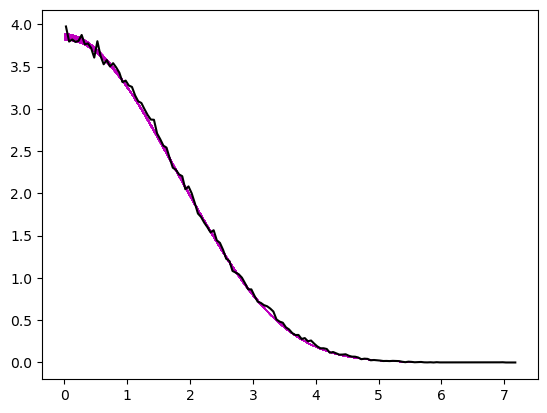

In [ ]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse_o,bcs[i],s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.show()

In [ ]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.85816083  0.74912035]
 [-0.85816083  1.         -0.97028133]
 [ 0.74912035 -0.97028133  1.        ]]


Note that parameters are highly correlated, as you can see by the correlation matrix  - there are multiple parameters that give essentially the same result. It may be a 2 parameter fit is enough!  Bootstrapping over osmotic coefficients should give less noisy results.

Parma 0 = 2.5360860549497555 +/- 0.45132468939424136


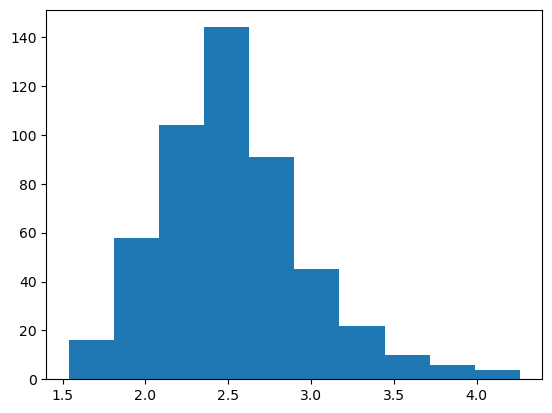

Parma 1 = 0.22423435320117868 +/- 0.024239947888289246


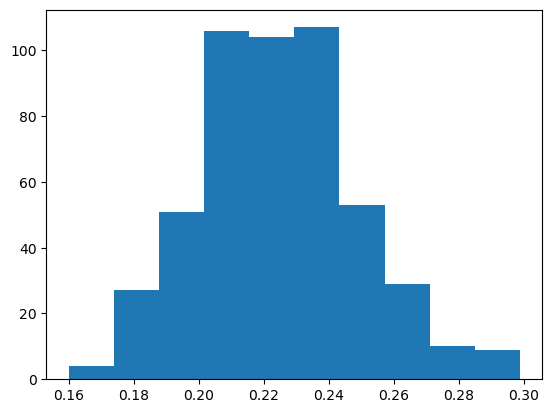

Parma 2 = -0.02069066468538973 +/- 0.003819749574090873


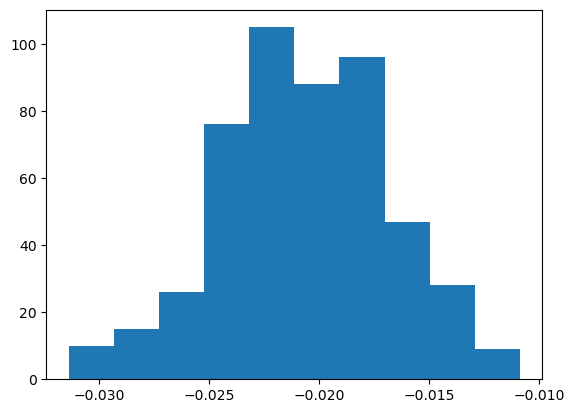

In [ ]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Note that the standard deviations of the parameters are lower with the maximum likelihood approximation.

B: 
weighted: 1.33 +/- 0.65
ML: 2.54 +/- 0.44

$\alpha_1$: 
weighted: 0.357 +/- 0.127
ML: 0.223 +/- 0.025

$\alpha_2$: 
weighted: -0.0317 +/- 0.0102
ML:  -0.0205 +/- 0.0041

Note that it is OK that the uncertainties are not within each other, since this is a highly correlated problem, so there are multiple solutions - small change in optimization can lead to large changes in the parameters while still being relatively close. 

In [ ]:
def osmotic_pressure(cs,params, nu=2):
    # takes in a concentration, model parameters and nu. 
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4)
    ip = nu*R*T*cs  # this should be the ideal osmotic pressure
    return p,p/ip

In [ ]:
op1m=osmotic_pressure(0.98,bparams)

In [ ]:
op1m

(array([13717.15232904,  4094.30525876,  2489.09964005]),
 array([2.80577247, 0.83746894, 0.50913244]))

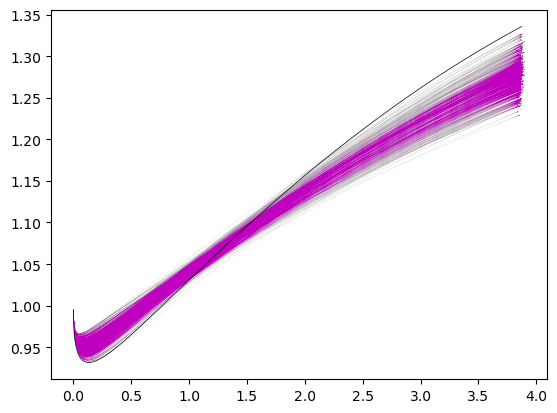

In [ ]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse,full_opt)[1]
plt.plot(c_opt_sparse,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

In [ ]:
lower_bound = np.percentile(ocs, 2.5, axis=0)
upper_bound = np.percentile(ocs, 97.5, axis=0)
# Plotting the results
plt.plot(c_opt_sparse, opt_oc, label='Mean Profile')
plt.fill_between(c_opt_sparse, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration')
plt.ylabel('Osmotic Coefficients')
plt.legend()
plt.title('Osmotic Coefficients From Maximum Likelihood Parameter Fitting')
plt.show()
plt.plot(np.log(c_opt_sparse), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()

NameError: name 'np' is not defined

How can I extract the osmotic values at each concentration?